In [1]:
import import_ipynb
import importlib
from importlib import reload

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

In [64]:
import util
import process
from sklearn.utils import shuffle

In [66]:
from process import get_labels, get_train_test_data, get_data

In [4]:
from util import sigmoid, relu, init_weight_bias, classification_rate, to_indicator, softmax, cost_mean

In [65]:
reload(process)

importing Jupyter notebook from process.ipynb


<module 'process' from 'process.ipynb'>

In [5]:
class ANN():
    def __init__(self, M):
        self.M = M
        
    def fit(self, X, Y, activation = 'relu', epochs = 10000, learning_rate = 1e-5, reg = 1e-1, show_fig = False, Xval = None, Yval = None) :
        N, D = X.shape
        K = len(set(Y))
        
        X, Y = shuffle(X, Y)
        val_used = False
        if Xval is not None and Yval is not None :
            val_used = True
            Xval, Yval = shuffle(Xval, Yval)
            Xval = cp.array(Xval)
            Yval = cp.array(Yval)
            Y_ind_val = to_indicator(Yval, K, usecupy=True)
                
        Y_ind = to_indicator(Y, K,usecupy=True)
        X = cp.array(X)
        Y = cp.array(Y)
        
        self.W1, self.b1 = init_weight_bias(D, self.M, usecupy=True)
        self.W2, self.b2 = init_weight_bias(self.M, K, usecupy=True)
        
        train_error = []
        val_error = []
        
        train_acc = []
        val_acc = []
        
        for i in range(epochs) :
            pY, Z = self.forward(X, activation)
            
            #gradient descent 
            self.W2 += learning_rate * (self.derivate_w2(Z, Y_ind, pY) - reg * self.W2)
            self.b2 += learning_rate * (self.derivate_b2(Y_ind, pY) - reg * self.b2)
            self.W1 += learning_rate * (self.derivate_w1(X, Y_ind, pY, self.W2, Z, activation) - reg * self.W1)
            self.b1 += learning_rate * (self.derivate_b1(Y_ind, pY, self.W2, Z, activation) - reg * self.b1)
            
            e = cost_mean(Y_ind,pY , usecupy=True)
            train_error.append(e.get())
            cl = classification_rate(Y.get(), pY.get().argmax(axis = 1))
            train_acc.append(cl)
            
            if val_used :
                pY_val, _ = self.forward(Xval, activation)
                e_val = cost_mean(Y_ind_val,pY_val , usecupy=True)
                val_error.append(e_val.get())
                cl_val = classification_rate(Yval.get(), pY_val.get().argmax(axis = 1))
                val_acc.append(cl_val)
            
            if i % 10 == 0:
                s =''
                if val_used :
                    s = f', val_error = {e_val}, val_acc = {cl_val}'
                print(f'i = {i}, train_error = {e}, train_acc = {cl}' + s)
            
        if show_fig:
            plt.figure()
            plt.title('Costs')
            plt.plot(train_error, label = 'Training errors')
            if val_used :
                plt.plot(val_error, label = 'Val errors')
            plt.xlabel('Epochs')
            plt.ylabel('Cost(mean)')
            plt.legend()
            plt.show()
            
            plt.figure()
            plt.title('Accuracy')
            plt.plot(train_acc, label = 'Training accuracy')
            if val_used :
                plt.plot(val_acc, label = 'Val accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()
        
    
    def derivate_w2(self, Z, T, Y) :
        return Z.T.dot(T - Y)
    
    def derivate_b2(self, T, Y) :
        return (T - Y).sum(axis = 0)
    
    def derivate_w1(self, X, T, Y, W2, Z, activation = 'relu') :
        if activation == 'sigmoid' :
            derivative_act = Z * (1 - Z)
        elif activation == 'tanh' :
            derivative_act = 1 - (Z * Z)
        elif activation == 'relu' :
            derivative_act = (Z > 0)
        return X.T.dot((T - Y).dot(W2.T) * derivative_act)
    
    def derivate_b1(self, T, Y, W2, Z, activation = 'relu') :
        if activation == 'sigmoid' :
            derivative_act = Z * (1 - Z)
        elif activation == 'tanh' :
            derivative_act = 1 - (Z * Z)
        elif activation == 'relu' :
            derivative_act = (Z > 0)
        return ((T - Y).dot(W2.T) * derivative_act).sum(axis = 0)
    
    def forward(self, X, activation = 'relu') :
        alpha = X.dot(self.W1) + self.b1
        if activation == 'sigmoid' :
            Z = sigmoid(alpha, usecupy=True)
        elif activation == 'tanh' :
            Z = cp.tanh(alpha)
        elif activation == 'relu' :
            Z = relu(alpha)
        
        return softmax(Z.dot(self.W2) + self.b2, usecupy=True), Z
    
    def accuracy(self, X, Y, activation = 'relu') :
        pY, _ = self.forward(X, activation)
        pY = pY.get()
        return classification_rate(Y, pY.argmax(axis = 1))
    
    def save(self, name) :
        cp.savez(name, self.W2, self.b2, self.W1, self.b1)

In [70]:
Xtrain = np.load('Xtrain_ANN.npy')
Ytrain = np.load('Ytrain_ANN.npy')
Xval = np.load('Xval_ANN.npy')
Yval = np.load('Yval_ANN.npy')

In [69]:
Xtrain, Ytrain, Xval, Yval = get_train_test_data(balance_ones=True)

yup


KeyboardInterrupt: 

In [74]:
Xtrain, Ytrain = get_data(4431)

In [44]:
np.save('Xtrain_ANN.npy', Xtrain)
np.save('Ytrain_ANN.npy', Ytrain)
np.save('Xval_ANN.npy', Xval)
np.save('Yval_ANN.npy', Yval)

i = 0, train_error = 0.28141076326640496, train_acc = 0.18054615211013314
i = 10, train_error = 0.2613164638141004, train_acc = 0.2547957571654254
i = 20, train_error = 0.2596120529905962, train_acc = 0.25772963213721506
i = 30, train_error = 0.2586665272728822, train_acc = 0.25795531482735273
i = 40, train_error = 0.257947999439507, train_acc = 0.2595350936583164
i = 50, train_error = 0.2573340965288254, train_acc = 0.26066350710900477
i = 60, train_error = 0.25678216864452535, train_acc = 0.2617919205596931
i = 70, train_error = 0.2562733732779997, train_acc = 0.2626946513202437
i = 80, train_error = 0.25579777824616323, train_acc = 0.2635973820807944
i = 90, train_error = 0.25534936217721, train_acc = 0.2642744301512074
i = 100, train_error = 0.25492405399378243, train_acc = 0.26472579553148273
i = 110, train_error = 0.2545188687520596, train_acc = 0.2656285262920334
i = 120, train_error = 0.2541314879338606, train_acc = 0.26675693974272174
i = 130, train_error = 0.2537600369524329,

i = 1100, train_error = 0.23700303940227088, train_acc = 0.3604152561498533
i = 1110, train_error = 0.23689821689379198, train_acc = 0.36131798691040395
i = 1120, train_error = 0.2367941255374857, train_acc = 0.36131798691040395
i = 1130, train_error = 0.23669076037065526, train_acc = 0.36131798691040395
i = 1140, train_error = 0.23658811587731132, train_acc = 0.36267208305122994
i = 1150, train_error = 0.23648618597004376, train_acc = 0.36357481381178064
i = 1160, train_error = 0.23638496399780978, train_acc = 0.36357481381178064
i = 1170, train_error = 0.23628444277601784, train_acc = 0.36425186188219366
i = 1180, train_error = 0.2361846146345259, train_acc = 0.36492890995260663
i = 1190, train_error = 0.23608547147884215, train_acc = 0.3651545926427443
i = 1200, train_error = 0.23598700485986665, train_acc = 0.36560595802301965
i = 1210, train_error = 0.23588920604786542, train_acc = 0.3658316407131573
i = 1220, train_error = 0.23579206610693718, train_acc = 0.3658316407131573
i = 1

i = 2180, train_error = 0.22858697724935825, train_acc = 0.3967501692620176
i = 2190, train_error = 0.22852751857274184, train_acc = 0.3967501692620176
i = 2200, train_error = 0.22846828580690134, train_acc = 0.3967501692620176
i = 2210, train_error = 0.22840927673489747, train_acc = 0.3969758519521553
i = 2220, train_error = 0.22835048915827888, train_acc = 0.3974272173324306
i = 2230, train_error = 0.22829192089684652, train_acc = 0.3974272173324306
i = 2240, train_error = 0.22823356978844309, train_acc = 0.3974272173324306
i = 2250, train_error = 0.22817543368876506, train_acc = 0.39787858271270593
i = 2260, train_error = 0.22811751047119783, train_acc = 0.3981042654028436
i = 2270, train_error = 0.22805979802667237, train_acc = 0.39787858271270593
i = 2280, train_error = 0.2280022942635421, train_acc = 0.39765290002256826
i = 2290, train_error = 0.22794499710747948, train_acc = 0.39765290002256826
i = 2300, train_error = 0.22788790450139004, train_acc = 0.3983299480929813
i = 2310,

i = 3260, train_error = 0.22310927802423247, train_acc = 0.41254795757165424
i = 3270, train_error = 0.22306481089193883, train_acc = 0.41254795757165424
i = 3280, train_error = 0.2230204224834549, train_acc = 0.4127736402617919
i = 3290, train_error = 0.2229761121169828, train_acc = 0.4129993229519296
i = 3300, train_error = 0.22293187911875706, train_acc = 0.41322500564206727
i = 3310, train_error = 0.22288772282293615, train_acc = 0.41345068833220494
i = 3320, train_error = 0.22284364257149503, train_acc = 0.41345068833220494
i = 3330, train_error = 0.2227996377141184, train_acc = 0.41345068833220494
i = 3340, train_error = 0.22275570760809563, train_acc = 0.41367637102234256
i = 3350, train_error = 0.22271185161821586, train_acc = 0.4141277364026179
i = 3360, train_error = 0.22266806911666479, train_acc = 0.4143534190927556
i = 3370, train_error = 0.22262435948292225, train_acc = 0.4141277364026179
i = 3380, train_error = 0.2225807221036607, train_acc = 0.4141277364026179
i = 3390,

i = 4340, train_error = 0.21865549539737164, train_acc = 0.4265402843601896
i = 4350, train_error = 0.2186167688304249, train_acc = 0.42676596705032727
i = 4360, train_error = 0.2185780773467384, train_acc = 0.42676596705032727
i = 4370, train_error = 0.21853942072013088, train_acc = 0.42676596705032727
i = 4380, train_error = 0.2185007987264826, train_acc = 0.42676596705032727
i = 4390, train_error = 0.21846221114371403, train_acc = 0.4269916497404649
i = 4400, train_error = 0.21842365775176462, train_acc = 0.4269916497404649
i = 4410, train_error = 0.2183851383325718, train_acc = 0.42744301512074023
i = 4420, train_error = 0.2183466526700502, train_acc = 0.4276686978108779
i = 4430, train_error = 0.21830820055007072, train_acc = 0.42834574588129093
i = 4440, train_error = 0.21826978176043965, train_acc = 0.42857142857142855
i = 4450, train_error = 0.21823139609087844, train_acc = 0.4290227939517039
i = 4460, train_error = 0.21819304333300307, train_acc = 0.4290227939517039
i = 4470, 

i = 5420, train_error = 0.21463844811533242, train_acc = 0.44346648612051454
i = 5430, train_error = 0.21460252308676037, train_acc = 0.4432408034303769
i = 5440, train_error = 0.21456661690833753, train_acc = 0.44301512074023924
i = 5450, train_error = 0.21453072947880664, train_acc = 0.4432408034303769
i = 5460, train_error = 0.2144948606974443, train_acc = 0.4432408034303769
i = 5470, train_error = 0.21445901046405538, train_acc = 0.4432408034303769
i = 5480, train_error = 0.2144231786789673, train_acc = 0.44346648612051454
i = 5490, train_error = 0.21438736524302468, train_acc = 0.4436921688106522
i = 5500, train_error = 0.21435157005758393, train_acc = 0.4436921688106522
i = 5510, train_error = 0.2143157930245081, train_acc = 0.4436921688106522
i = 5520, train_error = 0.21428003404616153, train_acc = 0.4439178515007899
i = 5530, train_error = 0.21424429302540507, train_acc = 0.44414353419092756
i = 5540, train_error = 0.21420856986559086, train_acc = 0.44414353419092756
i = 5550, 

i = 6500, train_error = 0.21084917632704225, train_acc = 0.4531708417964342
i = 6510, train_error = 0.21081478940751477, train_acc = 0.4531708417964342
i = 6520, train_error = 0.21078041272052192, train_acc = 0.4531708417964342
i = 6530, train_error = 0.21074604620308662, train_acc = 0.4531708417964342
i = 6540, train_error = 0.21071168979247232, train_acc = 0.45294515910629657
i = 6550, train_error = 0.21067734342618166, train_acc = 0.4527194764161589
i = 6560, train_error = 0.21064300704195518, train_acc = 0.45294515910629657
i = 6570, train_error = 0.21060868057776977, train_acc = 0.45339652448657186
i = 6580, train_error = 0.21057436397183762, train_acc = 0.45339652448657186
i = 6590, train_error = 0.2105400571626048, train_acc = 0.45362220717670954
i = 6600, train_error = 0.21050576008874983, train_acc = 0.45362220717670954
i = 6610, train_error = 0.2104714726891826, train_acc = 0.45362220717670954
i = 6620, train_error = 0.21043719490304302, train_acc = 0.45339652448657186
i = 66

i = 7580, train_error = 0.2071828165856006, train_acc = 0.4651320243737305
i = 7590, train_error = 0.2071492140644092, train_acc = 0.4653577070638682
i = 7600, train_error = 0.20711561614895416, train_acc = 0.46558338975400587
i = 7610, train_error = 0.20708202279662818, train_acc = 0.4662604378244189
i = 7620, train_error = 0.20704843396497485, train_acc = 0.4662604378244189
i = 7630, train_error = 0.2070148496116882, train_acc = 0.4664861205145565
i = 7640, train_error = 0.20698126969461195, train_acc = 0.4667118032046942
i = 7650, train_error = 0.20694769417173914, train_acc = 0.4667118032046942
i = 7660, train_error = 0.2069141230012117, train_acc = 0.4667118032046942
i = 7670, train_error = 0.20688055614131964, train_acc = 0.4664861205145565
i = 7680, train_error = 0.20684699355050074, train_acc = 0.4662604378244189
i = 7690, train_error = 0.20681343518734005, train_acc = 0.4664861205145565
i = 7700, train_error = 0.20677988101056927, train_acc = 0.4662604378244189
i = 7710, train

i = 8660, train_error = 0.20357240964958823, train_acc = 0.47844730309185285
i = 8670, train_error = 0.2035390864616304, train_acc = 0.47844730309185285
i = 8680, train_error = 0.2035057640475902, train_acc = 0.47844730309185285
i = 8690, train_error = 0.20347244237831388, train_acc = 0.47844730309185285
i = 8700, train_error = 0.20343912142474738, train_acc = 0.4786729857819905
i = 8710, train_error = 0.2034058011579356, train_acc = 0.4786729857819905
i = 8720, train_error = 0.20337248154902218, train_acc = 0.4786729857819905
i = 8730, train_error = 0.20333916256924886, train_acc = 0.47912435116226587
i = 8740, train_error = 0.20330584418995518, train_acc = 0.47912435116226587
i = 8750, train_error = 0.20327252638257812, train_acc = 0.47912435116226587
i = 8760, train_error = 0.2032392091186516, train_acc = 0.47935003385240355
i = 8770, train_error = 0.20320589236980613, train_acc = 0.47935003385240355
i = 8780, train_error = 0.2031725761077682, train_acc = 0.47957571654254116
i = 879

i = 9740, train_error = 0.19997251360916518, train_acc = 0.4917625818099752
i = 9750, train_error = 0.19993912374295533, train_acc = 0.4922139471902505
i = 9760, train_error = 0.19990573199759196, train_acc = 0.4922139471902505
i = 9770, train_error = 0.19987233835249435, train_acc = 0.4922139471902505
i = 9780, train_error = 0.1998389427871431, train_acc = 0.4922139471902505
i = 9790, train_error = 0.19980554528108044, train_acc = 0.4924396298803882
i = 9800, train_error = 0.19977214581390945, train_acc = 0.4924396298803882
i = 9810, train_error = 0.19973874436529415, train_acc = 0.4926653125705258
i = 9820, train_error = 0.199705340914959, train_acc = 0.4926653125705258
i = 9830, train_error = 0.19967193544268866, train_acc = 0.4924396298803882
i = 9840, train_error = 0.1996385279283278, train_acc = 0.4922139471902505
i = 9850, train_error = 0.19960511835178074, train_acc = 0.4924396298803882
i = 9860, train_error = 0.19957170669301127, train_acc = 0.4926653125705258
i = 9870, train_

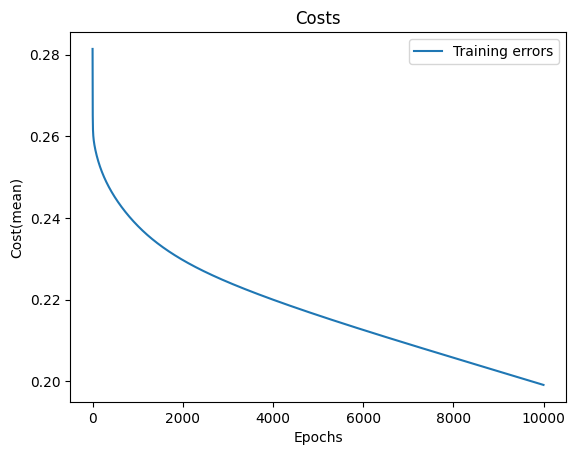

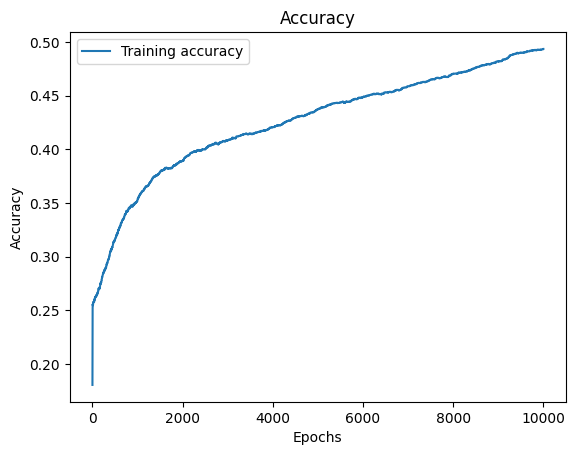

In [76]:
model = ANN(200)
model.fit(Xtrain, Ytrain, show_fig=True, activation = 'tanh', reg = 0.1, learning_rate = 1e-6, epochs = 10000)

In [1]:
model.save('weights_ANN')

NameError: name 'model' is not defined